# This notebook gives busineess action plans based on customer segments using RFM and Customer Life Time value

**In this notebook we have not only provided business insights for this particular data**

**but also built a generic function to calculate customer life time value**

In [1]:
#install the libraries
! pip install lifetimes
! pip install seaborn
! pip install dexplot
!pip install pyodbc

In [2]:
!jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [3]:
# Importing the libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import dexplot as dxp
import seaborn as sns
import pyodbc
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('data_with_cmp1.csv',usecols=['event_time','event_type','price','user_id','user_session','campion_1','campion_2','campion_3','campion_4','campion_5','start_date','used_discount']) #,sep='\t'

# df.set_index('ID',inplace=True,drop=True)
# df.index.name = None
df.head(10)

,event_time,event_type,price,user_id,user_session,campion_1,campion_2,campion_3,campion_4,campion_5,start_date,used_discount
0,2019-10-01 00:00:00+00:00,view,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,0,0,1,0,0,2019-10-01 00:00:00+00:00,0
1,2019-10-01 00:00:00+00:00,view,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,1,1,1,1,0,2019-10-01 00:00:00+00:00,0
2,2019-10-01 00:00:01+00:00,view,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,1,0,1,1,0,2019-10-01 00:00:01+00:00,0
3,2019-10-01 00:00:01+00:00,view,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,1,0,0,0,0,2019-10-01 00:00:01+00:00,0
4,2019-10-01 00:00:04+00:00,view,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1,1,0,1,0,2019-10-01 00:00:04+00:00,0
5,2019-10-01 00:00:05+00:00,view,908.62,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9,0,0,1,1,0,2019-10-01 00:00:05+00:00,0
6,2019-10-01 00:00:08+00:00,view,380.96,555447699,4fe811e9-91de-46da-90c3-bbd87ed3a65d,1,1,1,1,1,2019-10-01 00:00:08+00:00,0
7,2019-10-01 00:00:08+00:00,view,41.16,550978835,6280d577-25c8-4147-99a7-abc6048498d6,0,0,0,1,1,2019-10-01 00:00:08+00:00,0
8,2019-10-01 00:00:10+00:00,view,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,1,0,0,0,0,2019-10-01 00:00:10+00:00,0
9,2019-10-01 00:00:11+00:00,view,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb,0,1,0,0,0,2019-10-01 00:00:11+00:00,0


In [5]:
df['Dt_Customer'] = pd.to_datetime(df['start_date'])

In [6]:
data=df.loc[df.event_type == 'purchase']

In [7]:
%%time
data['event_time']=pd.to_datetime(data['event_time']).dt.tz_convert(None)


CPU times: total: 641 ms
Wall time: 641 ms


In [8]:
grouped_data=data.groupby(by='user_session').agg(Date_order=('event_time','max'),
                                        user_id=('user_id','unique'),
                                        Quantity=('user_session','count'),
                                        money_spent=('price','sum'),
                                        campion_1=('campion_1','max'),
                                        campion_2=('campion_2','max'),
                                        campion_3=('campion_3','max'),
                                        campion_4=('campion_4','max'),
                                        campion_5=('campion_5','max'),
                                        Dt_Customer=('Dt_Customer','min'),
                                        used_discount=('used_discount','sum')).reset_index(drop=True)
grouped_data

,Date_order,user_id,Quantity,money_spent,campion_1,campion_2,campion_3,campion_4,campion_5,Dt_Customer,used_discount
0,2019-10-06 11:34:30,[546521725],1,289.52,1,1,1,0,1,2019-10-06 11:24:45+00:00,0
1,2019-10-25 08:39:11,[560486342],1,171.90,0,1,1,1,1,2019-10-15 13:03:03+00:00,1
2,2019-10-17 13:37:59,[560744406],2,379.78,1,1,0,1,1,2019-10-16 07:35:48+00:00,1
3,2019-10-15 08:09:02,[520649833],1,90.07,1,1,0,1,0,2019-10-09 11:17:15+00:00,0
4,2019-10-23 14:27:08,[534210306],2,571.92,0,0,1,1,1,2019-10-04 23:25:27+00:00,2
...,...,...,...,...,...,...,...,...,...,...,...
629555,2019-10-29 05:18:45,[565273783],2,2715.20,1,1,1,1,0,2019-10-29 05:14:29+00:00,1
629556,2019-10-04 09:01:28,[548691169],1,193.03,1,0,1,1,0,2019-10-03 08:30:35+00:00,1
629557,2019-10-14 09:19:57,[560049739],1,131.64,0,1,1,0,1,2019-10-14 08:28:43+00:00,1
629558,2019-10-10 12:34:49,[517051774],1,130.12,1,1,0,0,0,2019-10-10 12:33:47+00:00,0


In [9]:
grouped_data['user_id'] = grouped_data['user_id'].astype('int')

In [10]:
grouped_data['Date_order'].max()

Timestamp('2019-10-31 23:59:16')

In [11]:
study_date = dt.datetime(2019,11,1)
grouped_data=pd.DataFrame(grouped_data)
grouped_data['last_purchase']=study_date - grouped_data['Date_order']
grouped_data['last_purchase'].dt.days
grouped_data['last_purchase']=grouped_data['last_purchase'] / np.timedelta64(1, 'D')
grouped_data.head()

,Date_order,user_id,Quantity,money_spent,campion_1,campion_2,campion_3,campion_4,campion_5,Dt_Customer,used_discount,last_purchase
0,2019-10-06 11:34:30,546521725,1,289.52,1,1,1,0,1,2019-10-06 11:24:45+00:00,0,25.517708
1,2019-10-25 08:39:11,560486342,1,171.90,0,1,1,1,1,2019-10-15 13:03:03+00:00,1,6.639456
2,2019-10-17 13:37:59,560744406,2,379.78,1,1,0,1,1,2019-10-16 07:35:48+00:00,1,14.431956
3,2019-10-15 08:09:02,520649833,1,90.07,1,1,0,1,0,2019-10-09 11:17:15+00:00,0,16.660394
4,2019-10-23 14:27:08,534210306,2,571.92,0,0,1,1,1,2019-10-04 23:25:27+00:00,2,8.397824


In [12]:
df_RFM= grouped_data.groupby('user_id').agg(Recency=('last_purchase','min'),
                                 Frequency=('user_id','count'),
                                 Monetary=('money_spent','sum'))
df_RFM.head()

,Recency,Frequency,Monetary
user_id,,,
264649825,25.141539,2,1240.04
303160429,18.440637,1,340.59
340041246,17.384965,3,915.52
371877401,22.339491,1,29.89
384989212,13.527789,1,41.44


# RFM Customer Segmentation 

**Recency**: Number of days since customer's last purchase

**Monetory Value**: Total monetary value the customer spent on   
Monetory Value = MntWines+ MntFruits+ MntMeatProducts+ MntFishProducts+ MntSweetProducts+ MntGoldProds    

**Frequency** = NumWebPurchases + NumCatalogPurchases + NumStorePurchases



In [13]:
# df_RFM = df[['ID','Recency']]
# df_RFM['Monetary'] =  df['MntWines']+ df['MntFruits']+ df['MntMeatProducts']+ df['MntFishProducts']+ df['MntSweetProducts']+ df['MntGoldProds']  
# df_RFM['Frequency'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

In [14]:
quintiles = df_RFM[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()

In [15]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5  

In [16]:
df_RFM['R'] = df_RFM['Recency'].apply(lambda x: r_score(x))
df_RFM['F'] = df_RFM['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
df_RFM['M'] = df_RFM['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [17]:
df_RFM['RFM Score'] = df_RFM['R'].map(str) + df_RFM['F'].map(str) + df_RFM['M'].map(str)

In [18]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

df_RFM['Segment'] = df_RFM['R'].map(str) + df_RFM['F'].map(str)
df_RFM['Segment'] = df_RFM['Segment'].replace(segt_map, regex=True)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
user_id,,,,,,,,
264649825,25.141539,2,1240.04,1,4,5,145,at risk
303160429,18.440637,1,340.59,2,1,4,214,hibernating
340041246,17.384965,3,915.52,2,5,5,255,can't loose
371877401,22.339491,1,29.89,2,1,1,211,hibernating
384989212,13.527789,1,41.44,3,1,1,311,about to sleep


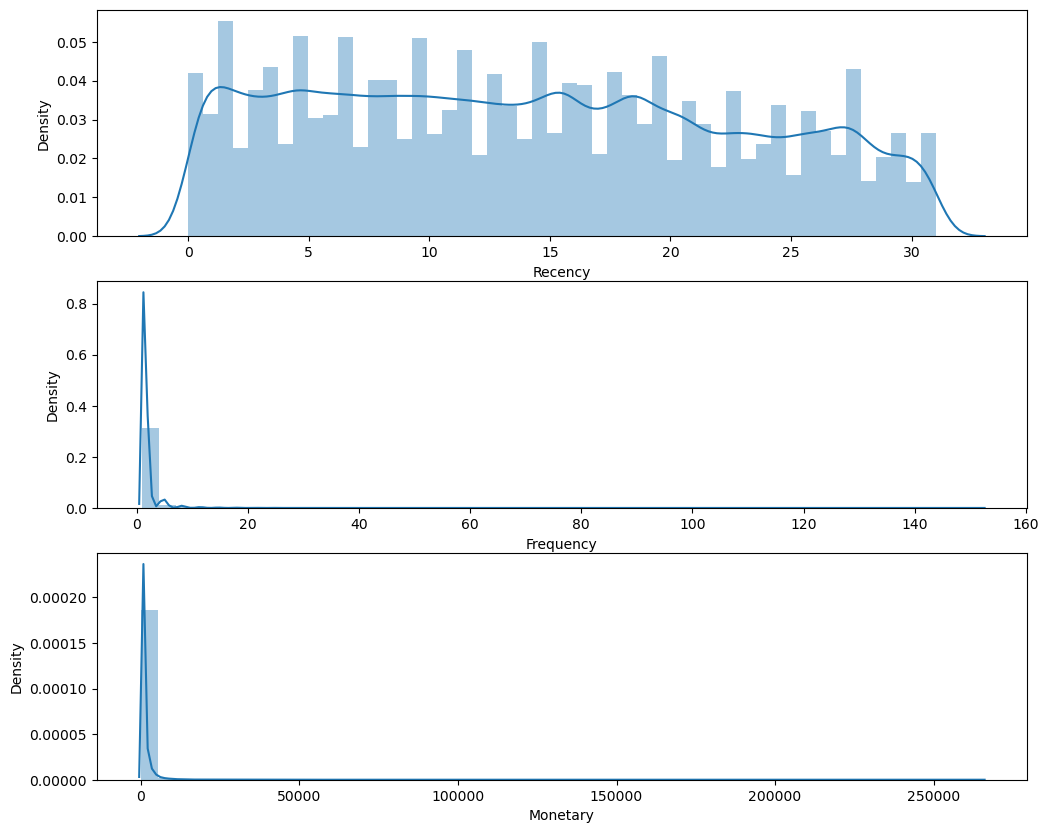

In [19]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(df_RFM['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df_RFM['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df_RFM['Monetary'])
# Show the plot
plt.show()

* Segment----------------------------->Description
* Champions-------------------------->Bought recently, buy often and spend the most
* Loyal Customers-------------------->Buy on a regular basis. Responsive to promotions.
* Potential Loyalist------------------->Recent customers with average frequency.
* Recent Customers------------------->Bought most recently, but not often.
* Promising---------------------------->Recent shoppers, but haven’t spent much.
* Customers Needing Attention------>Above average recency, frequency and monetary values. May not have bought very recently though.
* About To Sleep---------------------->Below average recency and frequency. Will lose them if not reactivated.
* At Risk------------------------------->Purchased often but a long time ago. Need to bring them back!
* Can’t Lose Them-------------------->Used to purchase frequently but haven’t returned for a long time.
* Hibernating------------------------->Last purchase was long back and low number of orders. May be lost.

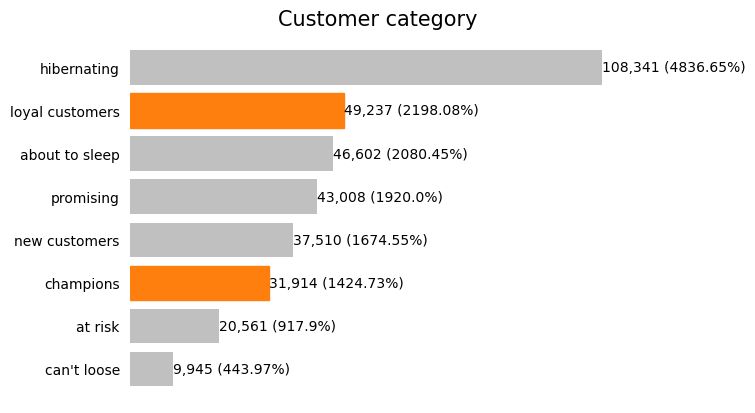

In [20]:
# count the number of customers in each segment
def customerSegmentPlot(df_RFM, title):
    segments_counts = df_RFM.value_counts().sort_values(ascending=True)

    fig, ax = plt.subplots()

    bars = ax.barh(range(len(segments_counts)),
                  segments_counts,
                  color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False,
                   bottom=False,
                   labelbottom=False)
    ax.set_yticks(range(len(segments_counts)))
    ax.set_yticklabels(segments_counts.index)
    ax.set_title(title,fontsize=15)
    for i, bar in enumerate(bars):
            value = bar.get_width()
            if segments_counts.index[i] in ['champions', 'loyal customers']:
                bar.set_color('C1')
            ax.text(value,
                    bar.get_y() + bar.get_height()/2,
                    '{:,} ({:}%)'.format(int(value),
                                       round(value*100/2240,2)),
                    va='center',
                    ha='left'
                   )

    plt.show()
    
customerSegmentPlot(df_RFM['Segment'], title ="Customer category")

In [21]:
df_RFM_score = grouped_data.merge(df_RFM,how='left',on='user_id')


In [22]:
df_RFM_score['NumDealsPurchases'] =  df_RFM_score['used_discount'].mask(df_RFM_score['used_discount']>5,5)

<AxesSubplot:xlabel='NumDealsPurchases', ylabel='Probability'>

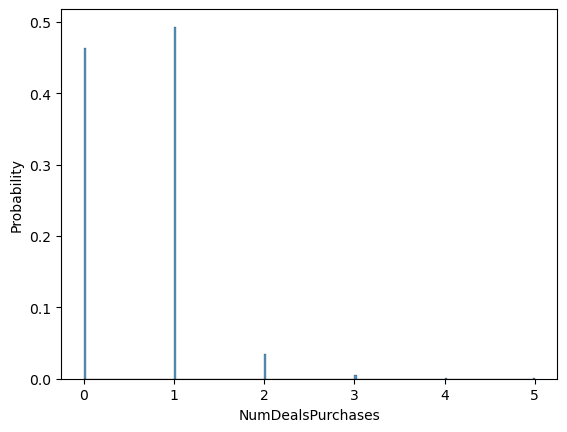

In [23]:
sns.histplot(df_RFM_score['NumDealsPurchases'],stat="probability")

# Are customers who use discount more often (>3) are loyal? 

**Most customers who use discounts often are champions.**

In [24]:
df_RFM_score.shape

(629560, 21)

In [25]:
grouped_data.shape

(629560, 12)

<AxesSubplot:xlabel='Probability', ylabel='Segment'>

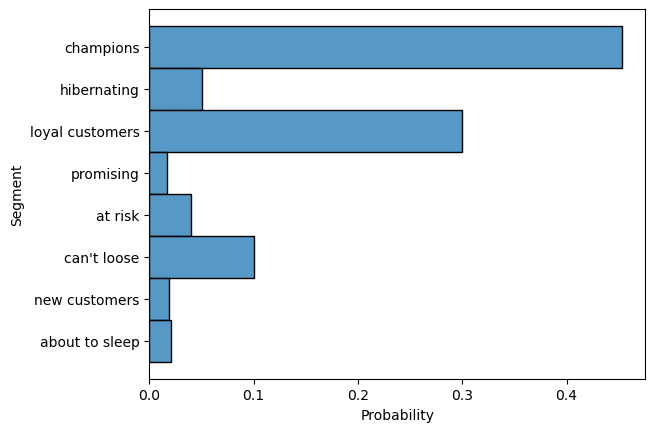

In [26]:
sns.histplot(df_RFM_score[df_RFM_score['NumDealsPurchases']>3],stat="probability", y="Segment")

# Interactive plot to select customer category based on number of purchases

Note: You have to take a copy and run this section for interactive use. 

In [27]:
print("Select Customer number of Discount purchases:")

dropdown = widgets.Dropdown(options = sorted(list(set(df_RFM_score['NumDealsPurchases']))))


@interact
def line_plot(NumDealsPurchases = sorted(df_RFM_score['NumDealsPurchases'].unique())):
    
    df_RFM_discount = df_RFM_score[df_RFM_score['NumDealsPurchases'] == NumDealsPurchases]['Segment']
    
    customerSegmentPlot(df_RFM_discount, title ="Customer categories for "+str(NumDealsPurchases) +" times discount used users"+
                        "  (Customer percentage ="+str(round(len(df_RFM_discount)*100/len(df_RFM_score),2))+" %)")
    
print("Note: All the percentages are calculated w.r.t total, they are not relative to specific category")

Select Customer number of Discount purchases:


interactive(children=(Dropdown(description='NumDealsPurchases', options=(0, 1, 2, 3, 4, 5), value=0), Output()…

Note: All the percentages are calculated w.r.t total, they are not relative to specific category


# Interactive plot to group customer category based on a specific column

Note: You have to take a copy and run this section for interactive use. 

In [28]:
print("Select Column Name:")

dropdown = widgets.Dropdown(options = sorted(list(set(df_RFM_score.columns))))
col_= df_RFM_score.dtypes==('int64' or 'float64')

@interact
def line_plot(col_name = sorted(col_[col_==True].index)):
    df__= df_RFM_score.groupby(['Segment']).mean().reset_index()
    sns.barplot(x=col_name, y="Segment", data=df__[['Segment',col_name]])
    plt.title("Customer segment w.r.t "+col_name)
    print(col_name)
    plt.show()

Select Column Name:


interactive(children=(Dropdown(description='col_name', options=('F', 'Frequency', 'M', 'NumDealsPurchases', 'Q…

# Estimating Customer lifetime Value using Gamma-Gamma Model 

### What is Customer Value?

Customer value or Customer Lifetime Value (CLV) is the total monetary value of transactions/purchases made by a customer with your business over his entire lifetime.

It’s crucial to understand the intuition behind CLV. These are the main assumptions that we make:

At each point in time, a customer can decide to buy

Probability of buying is unique for each user and it depends on the historical behaviour

Each customer can churn after a transaction

Probability of churn is unique for each user and it depends on the historical behaviour

#### **Customer Lifetime value** = (predicted number of transactions in the next quaterly/yearly) * (Expected average sales from that customer)

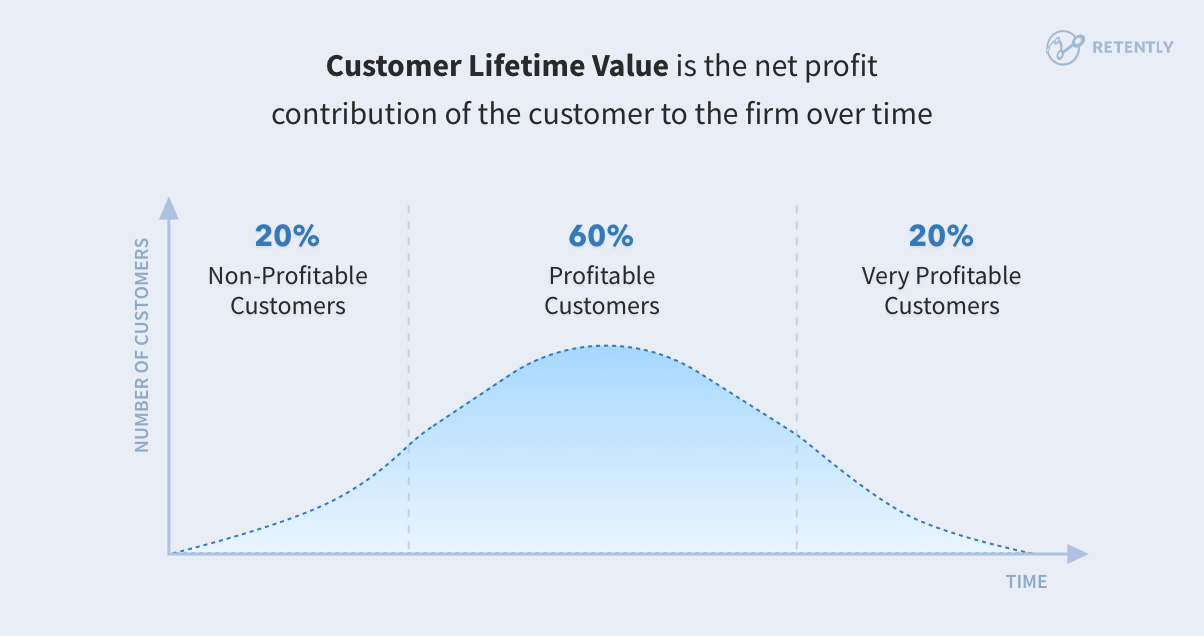

#### Buy Till You Die:
    
BTYD is built on 4 metrics which are closely related to the ones used for RFM segmentation:

**Recency:** The age of the customer when he made its last purchase (Last customer purchase date - first customer purchase date)
    
**T:** Customer's age. (how long before the analysis date the first purchase was made)
    
**Frequency:** The number of repeated purchases the customer made after his first date of first purchase
    
**Average Monetary:** The average amount spent by a customer
    
#### BG/NBD and Gamma-Gamma models in this project.

**BG/NBD:** It can be used to predict repeat visits by customers. In addition, the data allows us to understand whether the customer will come again.

**Gamma-Gamma:** It predicts how much money the customer will earn on average in a certain period of time.

#### Lifetimes

It is a valuable tool for businesses aiming to analyze and understand user behavior based on two key assumptions.

Firstly, it assumes that users are considered "alive" when they actively engage with a product or service, reflecting their ongoing interactions.

Secondly, it acknowledges that users under study may "die" or become inactive after a certain period of time, providing a framework for modeling customer churn and attrition. 

In [29]:
# Calculate the entire transation period of customers
df_RFM_score['T'] = ( df_RFM_score['Dt_Customer'].max()- df_RFM_score['Dt_Customer']).dt.days +90

## Modelling & EvaluationPermalink

#### Illustration of CustomerLifeTimeValue function

The modelling & evaluation process is going to be the following:

#### BG/NBD model

Fit BG/NBD model for frequency prediction by BetaGeoFitter class in Lifetimes package. 


**model.conditional_probability_alive():** This method computes the probability that a customer with history (frequency, recency, T) is currently alive.

Evaluate BG/NBD model for frequency prediction

**model.conditional_expected_number_of_purchases_up_to_time():** Calculate the expected number of repeat purchases up to time t for a randomly chosen individual from the population (or the whole population), given they have purchase history (frequency, recency, T).

The expected future transactions is predicted,Gamma-Gamma model is used to predict the future monetary value of each transaction.

#### Gamma-Gamma model 

Fit Gamma-Gamma model by GammaGammaFitter in Lifetimes package for monetary value prediction.

**model.conditional_expected_average_profit():** This method computes the conditional expectation of the average profit per transaction for a group of one or more customers.

**model.customer_lifetime_value():** This method computes the average lifetime value of a group of one or more customers. This method takes in the BG/NBD model and the prediction horizon as a parameter to calculate the CLV.



#### Calculations

1)Calculate the **customer lifetime value** directly using the method from the lifetime’s package.

2)Calculate the CLV manually from the predicted number of future transactions (pred_num_txn) and expected average sales per transaction (exp_avg_sales).

3)combine 2 models into CLV model and compare to baseline


In [30]:
def CustomerLifeTimeValue(df,penalizer_coef=0.01,months_to_predict=3, discount_rate=0.01):
    ''' 
    
    args = df must have Frequency(count), Recency(days), Monetary($) and T (Transation period in days)
    output = [['ID','predicted_clv','manual_predicted_clv']]
    '''

# Discount rate converts future cash flows (that is revenue/profits) into today’s money for the firm
# discount_rate=0.01 ----> monthly discount rate ~ 12.7% annually  
    import lifetimes
    import pandas as pd
    import numpy as np
    #       Filter out customer those who have never visited again 
    df = df[df['Frequency']>=1]
   #BG/NBD model is available as BetaGeoFitter class in Lifetimes package.
    bgf = lifetimes.BetaGeoFitter(penalizer_coef=penalizer_coef)
    bgf.fit(df['Frequency'], df['Recency'], df['T'])

    # Compute the customer alive probability
    df['probability_alive'] = bgf.conditional_probability_alive(df['Frequency'], df['Recency'], df['T'])

    # Predict future transaction for the next 90 (months_to_predict*30) days based on historical data
    transaction_date = months_to_predict*30
    df['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(transaction_date, 
                                                                                       df['Frequency'],
                                                                                       df['Recency'],
                                                                                       df['T']),2)


    df_repeated_customers = df.copy()
    # Modeling the monetary value using Gamma-Gamma Model from Lifetimes python library 
    ggf = lifetimes.GammaGammaFitter(penalizer_coef=penalizer_coef)
    ggf.fit(df_repeated_customers['Frequency'],
     df_repeated_customers['Monetary'])

    df_repeated_customers['exp_avg_sales'] = ggf.conditional_expected_average_profit(df_repeated_customers['Frequency'],
                                     df_repeated_customers['Monetary'])

    # predicted_clv --> predicted_annual_lifetime_value
    # Predicting Customer Lifetime Value for the next 3 months
    df_repeated_customers['predicted_clv'] = ggf.customer_lifetime_value(bgf,
                                     df_repeated_customers['Frequency'],
                                     df_repeated_customers['Recency'],
                                     df_repeated_customers['T'],
                                     df_repeated_customers['Monetary'],
                                     time=months_to_predict,     # lifetime in months
                                     freq='D',   # frequency in which the data is present(transaction_date)      
                                     discount_rate=discount_rate) # discount rate

    # Manual predict clv = Predicted no. of transactions * Expected avg sales 
    df_repeated_customers['manual_predicted_clv'] = (df_repeated_customers['pred_num_txn'] *
                                                     df_repeated_customers['exp_avg_sales'])

#     if the clv is nan impute with mean
#     df_repeated_customers['predicted_clv'].fillna(df_repeated_customers['predicted_clv'].mean(), inplace=True)
#     df_repeated_customers['manual_predicted_clv'].fillna(df_repeated_customers['manual_predicted_clv'].mean(), inplace=True)
    df_repeated_customers = df_repeated_customers.round(2)

    return df_repeated_customers[['user_id','predicted_clv','manual_predicted_clv']]

**Predict Customer lifetime value for the next Quaterly (3 months)**

In [31]:
clv = CustomerLifeTimeValue(df_RFM_score,months_to_predict=3)

**Quantile customers into two category**
* Profitable and 
* Non-Profitable

In [32]:
clv['clv_label'] = clv['predicted_clv']>0
clv['clv_label'] = clv['clv_label'].map({True: 'profitable', False: 'Non-profitable'})

# LeftMerge CLV on main df
df_RFM_score = df_RFM_score.merge(clv,how='left', on = 'user_id')

In [33]:
df_RFM_score

,Date_order,user_id,Quantity,money_spent,campion_1,campion_2,campion_3,campion_4,campion_5,Dt_Customer,...,R,F,M,RFM Score,Segment,NumDealsPurchases,T,predicted_clv,manual_predicted_clv,clv_label
0,2019-10-06 11:34:30,546521725,1,289.52,1,1,1,0,1,2019-10-06 11:24:45+00:00,...,4,5,5,455,loyal customers,0,115,0.00,0.00,Non-profitable
1,2019-10-06 11:34:30,546521725,1,289.52,1,1,1,0,1,2019-10-06 11:24:45+00:00,...,4,5,5,455,loyal customers,0,115,0.00,0.00,Non-profitable
2,2019-10-06 11:34:30,546521725,1,289.52,1,1,1,0,1,2019-10-06 11:24:45+00:00,...,4,5,5,455,loyal customers,0,115,0.00,0.00,Non-profitable
3,2019-10-06 11:34:30,546521725,1,289.52,1,1,1,0,1,2019-10-06 11:24:45+00:00,...,4,5,5,455,loyal customers,0,115,0.00,0.00,Non-profitable
4,2019-10-06 11:34:30,546521725,1,289.52,1,1,1,0,1,2019-10-06 11:24:45+00:00,...,4,5,5,455,loyal customers,0,115,0.00,0.00,Non-profitable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204243,2019-10-14 09:19:57,560049739,1,131.64,0,1,1,0,1,2019-10-14 08:28:43+00:00,...,5,5,5,555,champions,1,107,0.00,0.00,Non-profitable
3204244,2019-10-10 12:34:49,517051774,1,130.12,1,1,0,0,0,2019-10-10 12:33:47+00:00,...,2,1,2,212,hibernating,0,111,22.44,22.37,profitable
3204245,2019-10-04 08:53:59,519348985,1,360.34,1,0,0,1,0,2019-10-02 10:28:53+00:00,...,1,5,5,155,can't loose,0,119,71.54,77.37,profitable
3204246,2019-10-04 08:53:59,519348985,1,360.34,1,0,0,1,0,2019-10-02 10:28:53+00:00,...,1,5,5,155,can't loose,0,119,71.54,77.37,profitable


Text(0.5, 1.0, 'Percentage of profitable and non profitable customers')

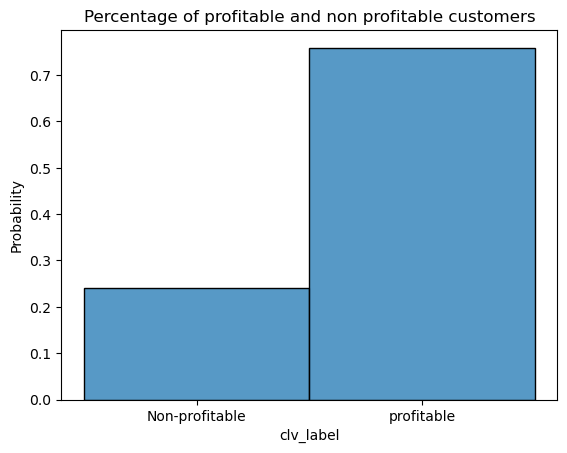

In [34]:
sns.histplot(clv['clv_label'],stat="probability")
plt.title("Percentage of profitable and non profitable customers")

**We observe that the majority clv scores are profitable**

# Interactive plot to groupby Profitable and Non-Profitable Customers based on a specific attribute 
Note: You have to take a copy and run this section for interactive use. 

In [35]:
print("Select Column Name:")

dropdown = widgets.Dropdown(options = sorted(list(set(df_RFM_score.columns))))
col_= df_RFM_score.dtypes==('int64' or 'float64')

@interact
def line_plot(col_name = sorted(col_[col_==True].index)):
    df__= df_RFM_score.groupby(['clv_label']).mean().reset_index()
    sns.barplot(x=col_name, y="clv_label", data=df__[['clv_label',col_name]])
    plt.title("Profitable and Non profitable customers in "+col_name)
    plt.show()



Select Column Name:


interactive(children=(Dropdown(description='col_name', options=('F', 'Frequency', 'M', 'NumDealsPurchases', 'Q…

**We observe that campaign 4 is the most profitable campaign**